<a href="https://colab.research.google.com/github/miczed/learny-mc-learnface/blob/master/PolicyGradient_LearnyMcLearnface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# COPIED FROM ALBERT
# installing dependencies
# remove > /dev/null 2>&1 if you want to see what is going on under the hood
!apt-get install -y python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[box2d] pyvirtualdisplay piglet PyOpenGL PyOpenGL-accelerate > /dev/null 2>&1
!apt-get install python-opengl -y
!apt-get update
!sudo apt install xvfb

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 67 not upgraded.
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.co

In [ ]:
# installing dependencies
# remove > /dev/null 2>&1 if you want to see what is going on under the hood
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[box2d] pyvirtualdisplay PyOpenGL PyOpenGL-accelerate > /dev/null 2>&1

#@title
# imports
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

In [ ]:
!pip install pyvirtualdisplay
!pip install piglet

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

'\nUtility functions to enable video recording of gym environment and displaying it\nTo enable video, just do "env = wrap_env(env)""\n'

In [ ]:
env = gym.make('CarRacing-v0')
observation = env.reset()

Track generation: 1112..1394 -> 282-tiles track


The observation returns a 96 x 96 array with RGB values:

In [ ]:
observation.shape

(96, 96, 3)

In [ ]:
env.action_space

Box(-1.0, 1.0, (3,), float32)

Which looks like this if we plot it:

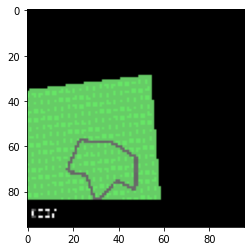

In [ ]:
plt.imshow(observation)

In [ ]:
def preprocess(observation):
    # crop
    observation = observation[0:84]  
    #greyscale
    observation = np.dot(observation[...,:3], [0.2989, 0.5870, 0.1140]) 
    # downsample
    observation = observation[0::2,0::2]
    # rescale numbers between 0 and 1
    max_val =observation.max() if observation.max()> abs(observation.min()) else abs(observation.min())
    if max_val != 0:
        observation=observation/max_val  
    return observation.astype(np.float32)

In [ ]:
random_action = env.action_space.sample()
random_action
observation, reward,done,info = env.step(random_action)

array([0.4954058 , 0.17857105, 0.41667834], dtype=float32)

In [ ]:
# do nothing for a couple of frames to wait until initial zoom-in animation is done
for x in range(15):
  observation, reward,done,info = env.step([0.0,0.0,0.0])

In [ ]:
#@title
processed_observation = preprocess(observation)
processed_observation.shape

(42, 48)

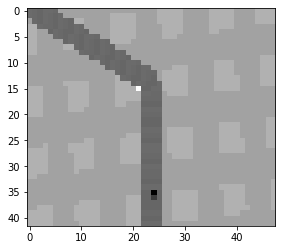

In [ ]:
plt.imshow(processed_observation,plt.cm.gray )

The Network consists of three layers.

In [ ]:
class PolicyGradientNetwork(tf.keras.Model):
    def __init__(self, n_actions, fc1_dims=256, fc2_dims=256):
        super(PolicyGradientNetwork, self).__init__()
        # is an integer since we're dealing with a discrete action space (policy gradient methods are best for this)
        self.n_actions = n_actions
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims

        # layers
        self.fc1 = tf.keras.layers.Dense(self.fc1_dims, activation='relu')
        self.fc2 = tf.keras.layers.Dense(self.fc2_dims, activation='relu')

        # will hold the policy, a probability distribution (sum = 1)
        self.pi = tf.keras.layers.Dense(self.n_actions, activation='softmax')

    def call(self, state):
        value = self.fc1(state)
        value = self.fc2(value)

        pi = self.pi(value)
        return pi


In [ ]:
class Agent:
    # alpha = learning rate
    # gamma = discount factor
    def __init__(self, alpha=0.003, gamma=0.99, n_actions=4, fc1_dims=256, fc2_dims=256):
        self.gamma = gamma
        self.alpha = alpha
        self.n_actions = n_actions
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []
        self.policy = PolicyGradientNetwork(n_actions=n_actions, fc1_dims=fc1_dims, fc2_dims=fc2_dims)
        self.policy.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.alpha))
        self.training_step = 0

    def choose_action(self, observation):
        state = tf.convert_to_tensor(observation, dtype=tf.float32)
        probs = self.policy(state)
        # categorical is used here since we have a set of discrete classes with some probability defined by probs
        action_probs = tfp.distributions.Categorical(probs=probs)
        action = action_probs.sample()

        # convert tensorflow tensor back to numpy array for our environment
        return action.numpy()[0][0]

    def store_transition(self, observation, action, reward):
        self.state_memory.append(observation)
        self.action_memory.append(action)
        self.reward_memory.append(reward)

    def learn(self):
        # convert the actions and rewards to a tensorflow tensor
        actions = tf.convert_to_tensor(self.action_memory, dtype=tf.float32)
        rewards = tf.convert_to_tensor(self.reward_memory)

        # calculate the discounted sum of future rewards for each timestep
        # discounting it ensures that the sum is finite in an infinite setting
        G = np.zeros_like(rewards)
        for t in range(len(rewards)):
            G_sum = 0
            discount = 1
            for k in range(t, len(rewards)):
                # sum of all rewards with discount applied
                G_sum += rewards[k] * discount
                # increasing the discount factor at each timestep
                discount *= self.gamma
                G[t] = G_sum
        # allows us to calculate the gradient
        with tf.GradientTape() as tape:
            loss = 0
            for idx, (g, state) in enumerate(zip(G, self.state_memory)):
                state = tf.convert_to_tensor([state], dtype=tf.float32)
                probs = self.policy(state)
                action_probs = tfp.distributions.Categorical(probs=probs)
                log_prob = action_probs.log_prob(actions[idx])
                # gradient ascent algorithm because we want to maximize total score
                loss += -g * tf.squeeze(log_prob)  # squeeze it to get it back to a scalar quantity
        gradient = tape.gradient(loss, self.policy.trainable_variables)
        self.policy.optimizer.apply_gradients(zip(gradient, self.policy.trainable_variables))

        # clear memory
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []

    def load_checkpoint(self,checkpoint_path):
        print('... Loading Checkpoint ...')
        self.policy.load_weights(checkpoint_path.format(epoch=0))

    def save_best_checkpoint(self,checkpoint_path,weights):
        print('... Saving Checkpoint ...')
        self.policy.set_weights(weights)
        self.policy.save_weights(checkpoint_path.format(epoch=0))
    def save_last_checkpoint(self,checkpoint_path):
        print('... Saving Checkpoint ...')
        self.policy.save_weights(checkpoint_path.format(epoch=0))

In [ ]:
class Env():
    """
    Environment wrapper for CarRacing
    """

    def __init__(self, repeat_actions=8, img_stack=4):
        self.env = gym.make('CarRacing-v0')
        self.reward_threshold = self.env.spec.reward_threshold
        self.repeat_actions = repeat_actions
        self.img_stack = img_stack

    def reset(self):
        self.counter = 0
        self.av_r = self.reward_memory()

        self.die = False
        img_rgb = self.env.reset()
        img_gray = self.preprocess(img_rgb)
        self.stack = [img_gray] * self.img_stack  # four frames for decision
        return np.array(self.stack)

    def step(self, action):
        total_reward = 0
        for i in range(self.repeat_actions):
            img_rgb, reward, die, _ = self.env.step(action)
            # don't penalize "die state"
            if die:
                reward += 100
            # green penalty
            if np.mean(img_rgb[:, :, 1]) > 185.0:
                reward -= 0.05
            total_reward += reward
            # if no reward recently, end the episode
            done = True if self.av_r(reward) <= -0.1 else False
            if done or die:
                break
        img = self.preprocess(img_rgb)
        self.stack.pop(0)
        self.stack.append(img)
        assert len(self.stack) == self.img_stack
        return np.array(self.stack), total_reward, done, die

    def render(self, *arg):
        self.env.render(*arg)

    @staticmethod
    def preprocess(observation):
        # crop
        observation = observation[0:84]
        # greyscale
        observation = np.dot(observation[..., :3], [0.2989, 0.5870, 0.1140])
        # downsample
        observation = observation[0::2, 0::2]
        # rescale numbers between 0 and 1
        max_val = observation.max() if observation.max() > abs(observation.min()) else abs(observation.min())
        if max_val != 0:
            observation = observation / max_val
        return observation.astype(np.float32)


    @staticmethod
    def reward_memory():
        # record reward for last 100 steps
        count = 0
        length = 100
        history = np.zeros(length)

        def memory(reward):
            nonlocal count
            history[count] = reward
            count = (count + 1) % length
            return np.mean(history)

        return memory

Todo: find a way to convert continuous action space to discrete action space

In [ ]:
def continuize_action(action):
    if action == 0: action = [0, 0, 0.0]  # Nothing
    if action == 1: action = [-1, 0, 0.0]  # Left
    if action == 2: action = [+1, 0, 0.0]  # Right
    if action == 3: action = [0, +1, 0.0]  # Accelerate
    if action == 4: action = [0, 0, 0.8]  # break
    return action

In [ ]:
best_weights=0
best_score=0

In [ ]:
env = Env()
agent = Agent(alpha=0.0005, gamma=0.99, n_actions=5, fc1_dims=96,fc2_dims=96)
score_history = []

n_episodes = 200
running_score = 0
state = env.reset()
#Load model if you have one, if it is the first iteration, set to false
load_dummy=True
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

for i in range(n_episodes):
    if load_dummy==True:
        agent.load_checkpoint(checkpoint_dir)
        load_dummy=False
    #Recall the last best reward
        #f= open("rewards.txt", "r")
        #last_line=f.readlines()[-1]
        #idx=last_line.find(' \n')
        #highest_score=float(last_line[0:idx])
        #f.close()

    score = 0
    observation = env.reset()

    for t in range(1000):
        discrete_action = agent.choose_action(observation)
        continuous_action = continuize_action(discrete_action)
        observation_, reward, done, die = env.step(continuous_action)
        env.render()
        agent.store_transition(observation, discrete_action, reward)
        score += reward
        observation = observation_
        if done or die:
            break
    #if highest_score<score:
    #    highest_score=score
    #    best_weights=agent.policy.get_weights()
    agent.learn()
    running_score = running_score * 0.99 + score * 0.01
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])
    if (i+1)%25==0:
    #This code saves the best weights (when higher_score>score for all score)
        #agent.save_best_checkpoint(checkpoint_dir,best_weights)
        #print("with score equal to: %.1f" % highest_score)
    #This code allows to access the last weights that were used (regardless the score they had)
        agent.save_last_checkpoint(checkpoint_dir)
        f = open("rewards.txt", "at")
        f.write("%.1f \n" % score)
        f.close()
    print('episode ', i+1, 'score %.1f' % score, 'avg score %.1f' % avg_score, 'running score: %.1f' % running_score)


Track generation: 1145..1435 -> 290-tiles track
... Loading Checkpoint ...
Track generation: 1261..1581 -> 320-tiles track
episode  1 score 17.6 avg score 17.6 running score: 0.2
Track generation: 1085..1360 -> 275-tiles track
episode  2 score 26.1 avg score 21.9 running score: 0.4
Track generation: 1055..1330 -> 275-tiles track
episode  3 score 11.4 avg score 18.4 running score: 0.5
Track generation: 1154..1454 -> 300-tiles track
episode  4 score 34.9 avg score 22.5 running score: 0.9
Track generation: 904..1144 -> 240-tiles track
episode  5 score 37.3 avg score 25.5 running score: 1.3
Track generation: 1167..1463 -> 296-tiles track
episode  6 score 30.9 avg score 26.4 running score: 1.5
Track generation: 1108..1389 -> 281-tiles track
episode  7 score 3.3 avg score 23.1 running score: 1.6
Track generation: 1179..1478 -> 299-tiles track
episode  8 score 19.5 avg score 22.6 running score: 1.7
Track generation: 853..1073 -> 220-tiles track
retry to generate track (normal if there are not

5

episode  25 score 9.0 avg score 22.6 running score: 5.0
Track generation: 1236..1549 -> 313-tiles track
episode  26 score 29.3 avg score 22.8 running score: 5.2
Track generation: 1286..1612 -> 326-tiles track
episode  27 score 28.1 avg score 23.0 running score: 5.4
Track generation: 1323..1658 -> 335-tiles track
episode  28 score -0.7 avg score 22.2 running score: 5.4
Track generation: 1231..1543 -> 312-tiles track
episode  29 score 13.3 avg score 21.9 running score: 5.4
Track generation: 1228..1539 -> 311-tiles track
episode  30 score 32.4 avg score 22.2 running score: 5.7
Track generation: 1151..1443 -> 292-tiles track
episode  31 score 57.1 avg score 23.4 running score: 6.2
Track generation: 1119..1403 -> 284-tiles track
episode  32 score 9.4 avg score 22.9 running score: 6.3
Track generation: 1243..1558 -> 315-tiles track
episode  33 score 29.7 avg score 23.1 running score: 6.5
Track generation: 1143..1433 -> 290-tiles track
episode  34 score 47.6 avg score 23.8 running score: 6.9


6

episode  50 score 25.2 avg score 26.3 running score: 10.6
Track generation: 1094..1376 -> 282-tiles track
episode  51 score 18.9 avg score 26.2 running score: 10.7
Track generation: 1295..1623 -> 328-tiles track
episode  52 score 27.7 avg score 26.2 running score: 10.8
Track generation: 965..1212 -> 247-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1111..1393 -> 282-tiles track
episode  53 score 37.9 avg score 26.4 running score: 11.1
Track generation: 1099..1386 -> 287-tiles track
episode  54 score 9.9 avg score 26.1 running score: 11.1
Track generation: 1125..1410 -> 285-tiles track
episode  55 score 2.2 avg score 25.7 running score: 11.0
Track generation: 1128..1414 -> 286-tiles track
episode  56 score 9.7 avg score 25.4 running score: 11.0
Track generation: 1280..1604 -> 324-tiles track
episode  57 score 3.6 avg score 25.0 running score: 10.9
Track generation: 1081..1355 -> 274-tiles track
episode  58 score 23.7 avg sc

6

episode  75 score 30.3 avg score 23.3 running score: 12.0
Track generation: 1144..1441 -> 297-tiles track
episode  76 score 5.1 avg score 23.1 running score: 12.0
Track generation: 1047..1313 -> 266-tiles track
episode  77 score 27.3 avg score 23.1 running score: 12.1
Track generation: 1222..1532 -> 310-tiles track
episode  78 score 0.5 avg score 22.8 running score: 12.0
Track generation: 1145..1435 -> 290-tiles track
episode  79 score 24.0 avg score 22.8 running score: 12.1
Track generation: 1147..1444 -> 297-tiles track
episode  80 score 12.3 avg score 22.7 running score: 12.1
Track generation: 1193..1501 -> 308-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1060..1337 -> 277-tiles track
episode  81 score 63.3 avg score 23.2 running score: 12.6
Track generation: 1176..1474 -> 298-tiles track
episode  82 score 25.0 avg score 23.2 running score: 12.8
Track generation: 1145..1435 -> 290-tiles track
episode  83 score 9.2 avg 

6

episode  100 score -2.4 avg score 22.0 running score: 13.3
Track generation: 1164..1459 -> 295-tiles track
episode  101 score 17.2 avg score 22.0 running score: 13.3
Track generation: 1205..1510 -> 305-tiles track
episode  102 score -18.1 avg score 21.5 running score: 13.0
Track generation: 1287..1613 -> 326-tiles track
episode  103 score 8.3 avg score 21.5 running score: 13.0
Track generation: 963..1208 -> 245-tiles track
episode  104 score 10.6 avg score 21.3 running score: 12.9
Track generation: 1132..1424 -> 292-tiles track
episode  105 score 6.0 avg score 21.0 running score: 12.9
Track generation: 949..1199 -> 250-tiles track
episode  106 score -0.2 avg score 20.6 running score: 12.7
Track generation: 1196..1499 -> 303-tiles track
episode  107 score 15.4 avg score 20.8 running score: 12.8
Track generation: 1036..1299 -> 263-tiles track
episode  108 score 1.6 avg score 20.6 running score: 12.7
Track generation: 1186..1487 -> 301-tiles track
episode  109 score -18.2 avg score 19.9 r

6

episode  125 score 55.7 avg score 19.0 running score: 12.8
Track generation: 1363..1708 -> 345-tiles track
episode  126 score -2.9 avg score 18.6 running score: 12.6
Track generation: 1040..1313 -> 273-tiles track
episode  127 score -2.6 avg score 18.3 running score: 12.5
Track generation: 949..1197 -> 248-tiles track
episode  128 score -18.0 avg score 18.2 running score: 12.2
Track generation: 1271..1593 -> 322-tiles track
episode  129 score 15.4 avg score 18.2 running score: 12.2
Track generation: 1109..1398 -> 289-tiles track
episode  130 score 11.7 avg score 18.0 running score: 12.2
Track generation: 1047..1313 -> 266-tiles track
episode  131 score -18.1 avg score 17.2 running score: 11.9
Track generation: 1273..1595 -> 322-tiles track
episode  132 score 0.9 avg score 17.1 running score: 11.8
Track generation: 1211..1522 -> 311-tiles track
episode  133 score 32.8 avg score 17.2 running score: 12.0
Track generation: 1129..1422 -> 293-tiles track
episode  134 score 8.8 avg score 16.8

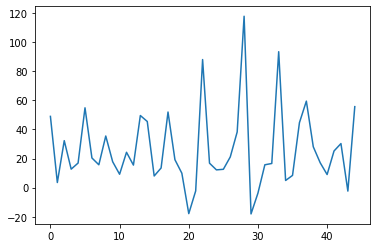

In [ ]:
f= open("rewards.txt", "r")
s=[]
for i in f.readlines():
    idx=i.find(' \n')
    rew=float(i[0:idx])
    s.append(rew)
f.close()
plt.plot(s)